# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(2898, 32, 32, 3)
(2898, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [4]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(64, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 32)         

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [5]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Epoch 1/30
290/290 [==============================] - 27s 92ms/step - loss: 0.1741 - accuracy: 0.8318 - val_loss: 0.0113 - val_accuracy: 0.9724
Epoch 2/30
290/290 [==============================] - 27s 93ms/step - loss: 0.0162 - accuracy: 0.9556 - val_loss: 0.0173 - val_accuracy: 0.9500
Epoch 3/30
290/290 [==============================] - 28s 96ms/step - loss: 0.0124 - accuracy: 0.9607 - val_loss: 0.0100 - val_accuracy: 0.9655
Epoch 4/30
290/290 [==============================] - 29s 101ms/step - loss: 0.0097 - accuracy: 0.9646 - val_loss: 0.0166 - val_accuracy: 0.9655
Epoch 5/30
290/290 [==============================] - 39s 136ms/step - loss: 0.0078 - accuracy: 0.9750 - val_loss: 0.0063 - val_accuracy: 0.9586
Epoch 6/30
290/290 [==============================] - 33s 114ms/step - loss: 0.0060 - accuracy: 0.9737 - val_loss: 0.0058 - val_accuracy: 0.9483
Epoch 7/30
290/290 [==============================] - 26s 90ms/step - loss: 0.0052 - accuracy: 0.9797 - val_loss: 0.0038 - val_accura

### Step 1: Learing result
 
* Visualization of the training and validation results

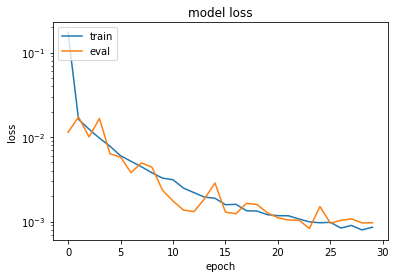

In [6]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [7]:
Batch_Size = 8
Epoch_Anz = 60
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Epoch 1/60
290/290 [==============================] - 42s 146ms/step - loss: 0.0495 - accuracy: 0.9284 - val_loss: 0.0084 - val_accuracy: 0.9690
Epoch 2/60
290/290 [==============================] - 35s 121ms/step - loss: 0.0079 - accuracy: 0.9702 - val_loss: 0.0055 - val_accuracy: 0.9810
Epoch 3/60
290/290 [==============================] - 34s 117ms/step - loss: 0.0055 - accuracy: 0.9741 - val_loss: 0.0079 - val_accuracy: 0.9776
Epoch 4/60
290/290 [==============================] - 32s 112ms/step - loss: 0.0046 - accuracy: 0.9698 - val_loss: 0.0036 - val_accuracy: 0.9724
Epoch 5/60
290/290 [==============================] - 31s 108ms/step - loss: 0.0040 - accuracy: 0.9741 - val_loss: 0.0039 - val_accuracy: 0.9810
Epoch 6/60
290/290 [==============================] - 31s 107ms/step - loss: 0.0033 - accuracy: 0.9802 - val_loss: 0.0027 - val_accuracy: 0.9828
Epoch 7/60
290/290 [==============================] - 33s 114ms/step - loss: 0.0033 - accuracy: 0.9814 - val_loss: 0.0092 - val_ac

290/290 [==============================] - 27s 95ms/step - loss: 7.3174e-04 - accuracy: 0.9879 - val_loss: 9.3569e-04 - val_accuracy: 0.9914
Epoch 57/60
290/290 [==============================] - 27s 94ms/step - loss: 7.3474e-04 - accuracy: 0.9871 - val_loss: 0.0010 - val_accuracy: 0.9914
Epoch 58/60
290/290 [==============================] - 26s 90ms/step - loss: 7.0244e-04 - accuracy: 0.9901 - val_loss: 8.2311e-04 - val_accuracy: 0.9914
Epoch 59/60
290/290 [==============================] - 34s 118ms/step - loss: 7.5283e-04 - accuracy: 0.9853 - val_loss: 7.8185e-04 - val_accuracy: 0.9966
Epoch 60/60
290/290 [==============================] - 27s 94ms/step - loss: 6.8939e-04 - accuracy: 0.9871 - val_loss: 9.7863e-04 - val_accuracy: 0.9914


### Overall Learing results (Step 1 & Step 2)

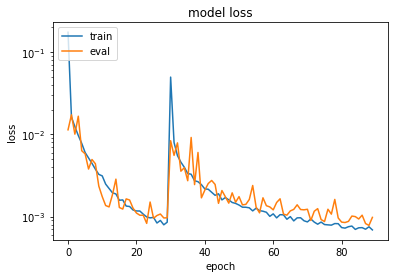

In [8]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(loss_ges)
plt.semilogy(val_loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).

In [9]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
i = 0

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    i+=1

res = np.asarray(res)
res_step_1 = res

## Results

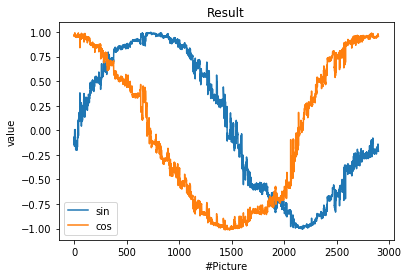

In [10]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

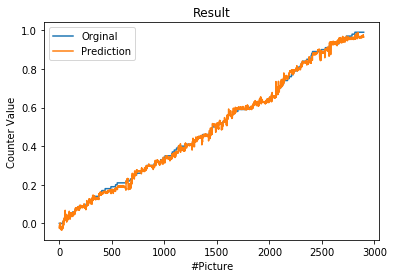

In [11]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

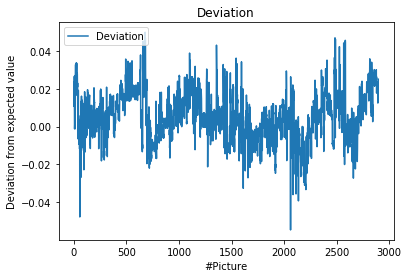

[ 0.0053  0.0126 -0.0546  0.0499]


In [12]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [13]:
model.save("CNN_Analog-Readout_Version-4.0.0.h5")